# Energy Consumption Forecasting
***
## Table of Contents
***

In [1]:
import torch
import os
import random
from typing import Callable
from torch import nn
from tqdm import tqdm
import numpy as np
from typing import List, Tuple, Optional, Dict
from numpy.typing import NDArray
import pandas as pd
import seaborn as sns
from pathlib import Path
from torch.utils.data import DataLoader, Subset, TensorDataset
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

## 1. Introduction

## 2. Device Agnostic-Code
Mac GPU acceleration (`mps` backend) delivers significant speed-up over CPU for deep learning tasks, especially for large models and batch sizes. On Windows, `cuda` is used instead of `mps`.

However, during the training process, I encountered several issues with LSTM networks on the MPS backend (e.g., error metrics became substantially higher compared to the CPU, etc.). Therefore, the CPU will be used throughout this project for '*safety*'.

**Reference**:
- [Training results from using MPS backend are poor compared to CPU and CUDA](https://github.com/pytorch/pytorch/issues/109457)
- [MPS backend produces bad training results in comparison to other backends](https://github.com/pytorch/pytorch/issues/92615)
- [Memory Leak in MPS Backend During LSTM Iterations (Out of Memory Error)](https://github.com/pytorch/pytorch/issues/145374)

In [2]:
# Set device
# device = "cuda" if torch.cuda.is_available() else "cpu"  # For Windows
# device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")  # For Mac
device = torch.device("cpu")  # For Mac, safer device use
device

device(type='cpu')

## 3. Loading Dataset
Retrieved from [Kaggle - Hourly Energy Consumption](https://www.kaggle.com/datasets/robikscube/hourly-energy-consumption)

In [3]:
df = pd.read_csv(
    "_datasets/energy_consumption_pjm/AEP_hourly.csv",
    parse_dates=["Datetime"],
    index_col="Datetime",
)
df.rename(columns={df.columns[0]: "Energy_Consumption_MW"}, inplace=True)

In [4]:
print("=" * 50)
print(df.head())
print("=" * 50)
print(f"Shape of the dataset: {df.shape}")
print("=" * 50)
print(df.info())
print("=" * 50)
print(f"Count of null values: {df.isnull().sum().sum()}")
print("=" * 50)
print(df.describe())

                     Energy_Consumption_MW
Datetime                                  
2004-12-31 01:00:00                13478.0
2004-12-31 02:00:00                12865.0
2004-12-31 03:00:00                12577.0
2004-12-31 04:00:00                12517.0
2004-12-31 05:00:00                12670.0
Shape of the dataset: (121273, 1)
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 121273 entries, 2004-12-31 01:00:00 to 2018-01-02 00:00:00
Data columns (total 1 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   Energy_Consumption_MW  121273 non-null  float64
dtypes: float64(1)
memory usage: 1.9 MB
None
Count of null values: 0
       Energy_Consumption_MW
count          121273.000000
mean            15499.513717
std              2591.399065
min              9581.000000
25%             13630.000000
50%             15310.000000
75%             17200.000000
max             25695.000000


## Feature Engineering

In [5]:
df["Year"] = df.index.year
df["Month"] = df.index.month
df["Dayofweek"] = df.index.dayofweek
df["Day"] = df.index.day_name()
df["Hour"] = df.index.hour
df = df.sort_index()

df.head()

,Energy_Consumption_MW,Year,Month,Dayofweek,Day,Hour
Datetime,,,,,,
2004-10-01 01:00:00,12379.0,2004,10,4,Friday,1
2004-10-01 02:00:00,11935.0,2004,10,4,Friday,2
2004-10-01 03:00:00,11692.0,2004,10,4,Friday,3
2004-10-01 04:00:00,11597.0,2004,10,4,Friday,4
2004-10-01 05:00:00,11681.0,2004,10,4,Friday,5


## Exploratory Data Analysis

In [6]:
def plot_overview_stats(df: pd.DataFrame) -> None:
    """
    Plot overview statistics and visualisations of energy consumption statistics.

    Args:
        DataFrame containing the columns 'Energy_Consumption_MW', 'Year', 'Day', and 'Hour'.
    """
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16, 10))
    axes = axes.flatten()

    sns.histplot(df["Energy_Consumption_MW"], kde=True, edgecolor="black", ax=axes[0])
    axes[0].lines[0].set_color("crimson")
    axes[0].set_title("Distribution of Energy Consumption")
    axes[0].set_xlabel("Energy Consumption (MW)")

    sns.lineplot(df, x="Year", y="Energy_Consumption_MW", ax=axes[1], marker="o")
    axes[1].set_title("Average Energy Consumption vs Year")
    axes[1].set_ylabel("Energy Consumption (MW)")
    axes[1].set_xlabel("Year")
    axes[1].set_xticks(range(df["Year"].min(), df["Year"].max() + 1, 1))
    axes[1].tick_params(axis="x", labelrotation=45)

    sns.barplot(
        df,
        x="Day",
        y="Energy_Consumption_MW",
        edgecolor="black",
        ax=axes[2],
        hue="Day",
        palette="Set2",
    )
    axes[2].set_title("Average Energy Consumption vs Day of Week")
    axes[2].set_xlabel("Energy Consumption (MW)")
    axes[2].tick_params(axis="x", labelrotation=45)

    sns.lineplot(
        df,
        x="Hour",
        y="Energy_Consumption_MW",
        ax=axes[3],
        marker="o",
    )
    axes[3].set_title("Average Energy Consumption vs Hour")
    axes[3].set_ylabel("Energy Consumption (MW)")
    axes[3].set_xlabel("Hour")
    axes[3].set_xticks(range(0, 24, 1))
    plt.tight_layout()
    plt.show()

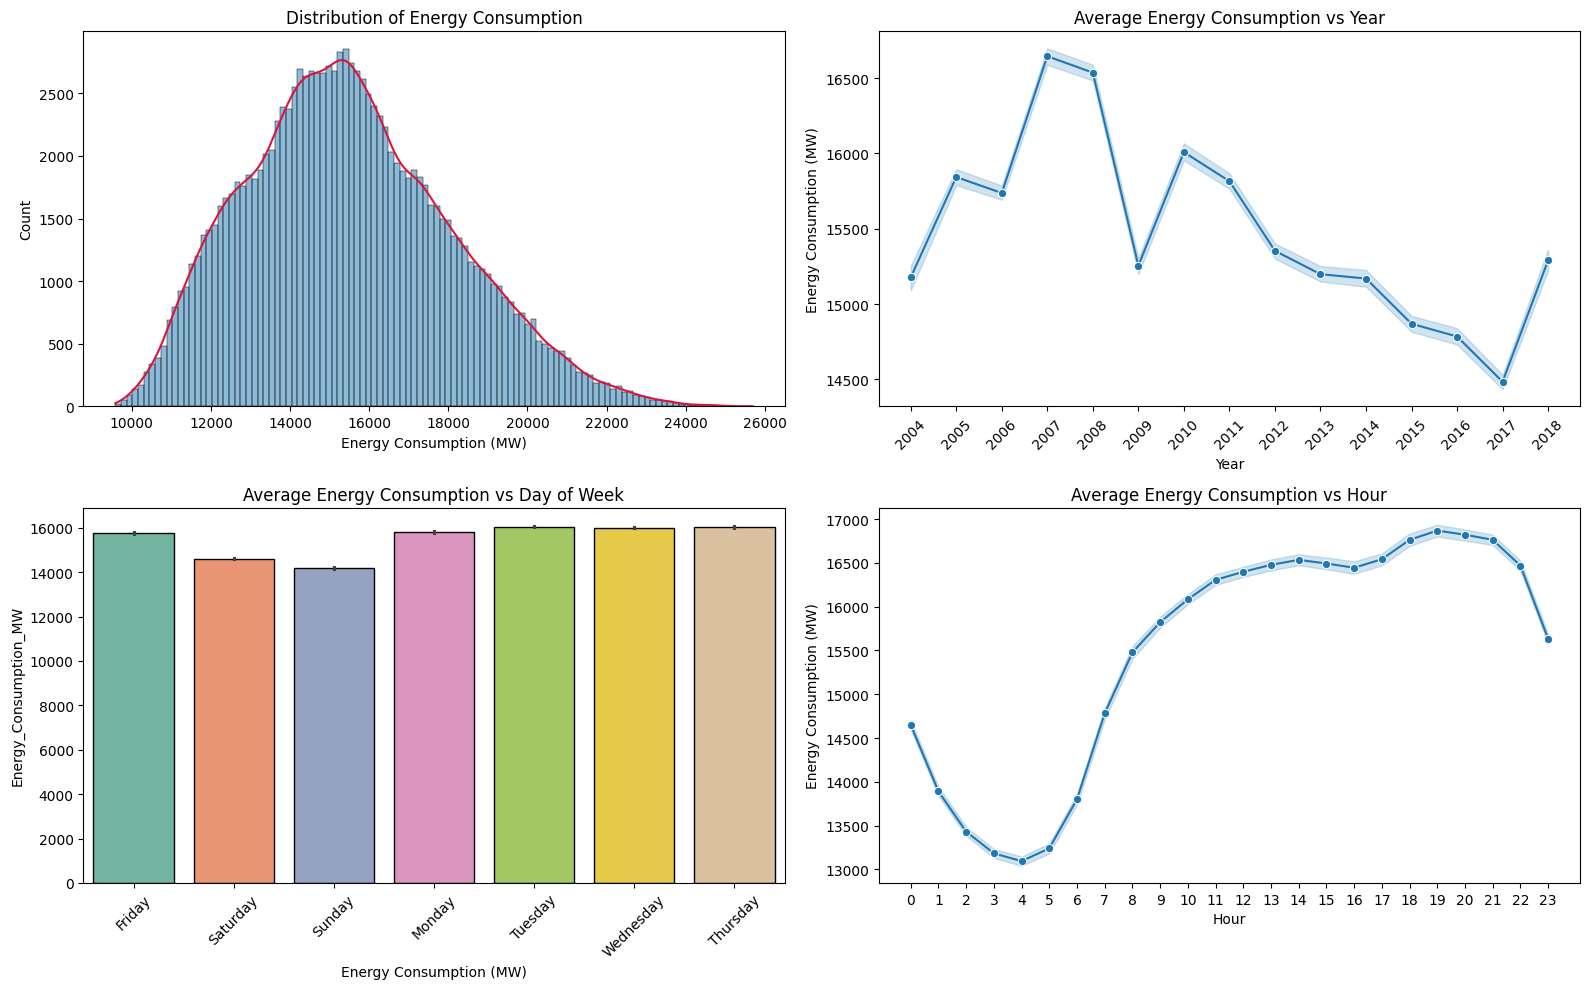

In [7]:
plot_overview_stats(df)

In [8]:
def plot_monthly_stats(df: pd.DataFrame, years_list: List[int]) -> None:
    """
    Plot average monthly energy consumption for multiple specified years.

    Args:
        df: DataFrame containing columns 'Month', 'Year', 'Energy_Consumption_MW'.
        years_list: List of years (as integers) for which to plot statistics.

    """
    n_figures = len(years_list)

    fig, axes = plt.subplots(nrows=n_figures, ncols=2, figsize=(16, n_figures * 3))
    axes = axes.flatten()
    for i, year in enumerate(years_list):
        ax = axes[i]
        df_year = df[df["Year"] == year]
        sns.lineplot(
            data=df_year, x="Month", y="Energy_Consumption_MW", ax=ax, marker="o"
        )
        ax.set_title(f"Average Energy Consumption vs Month in {year}")
        ax.set_ylabel("Energy Consumption (MW)")
        ax.set_xlabel("Month")
        ax.set_xticks(range(1, 13))

    if n_figures < len(axes):
        for j in range(n_figures, len(axes)):
            plt.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

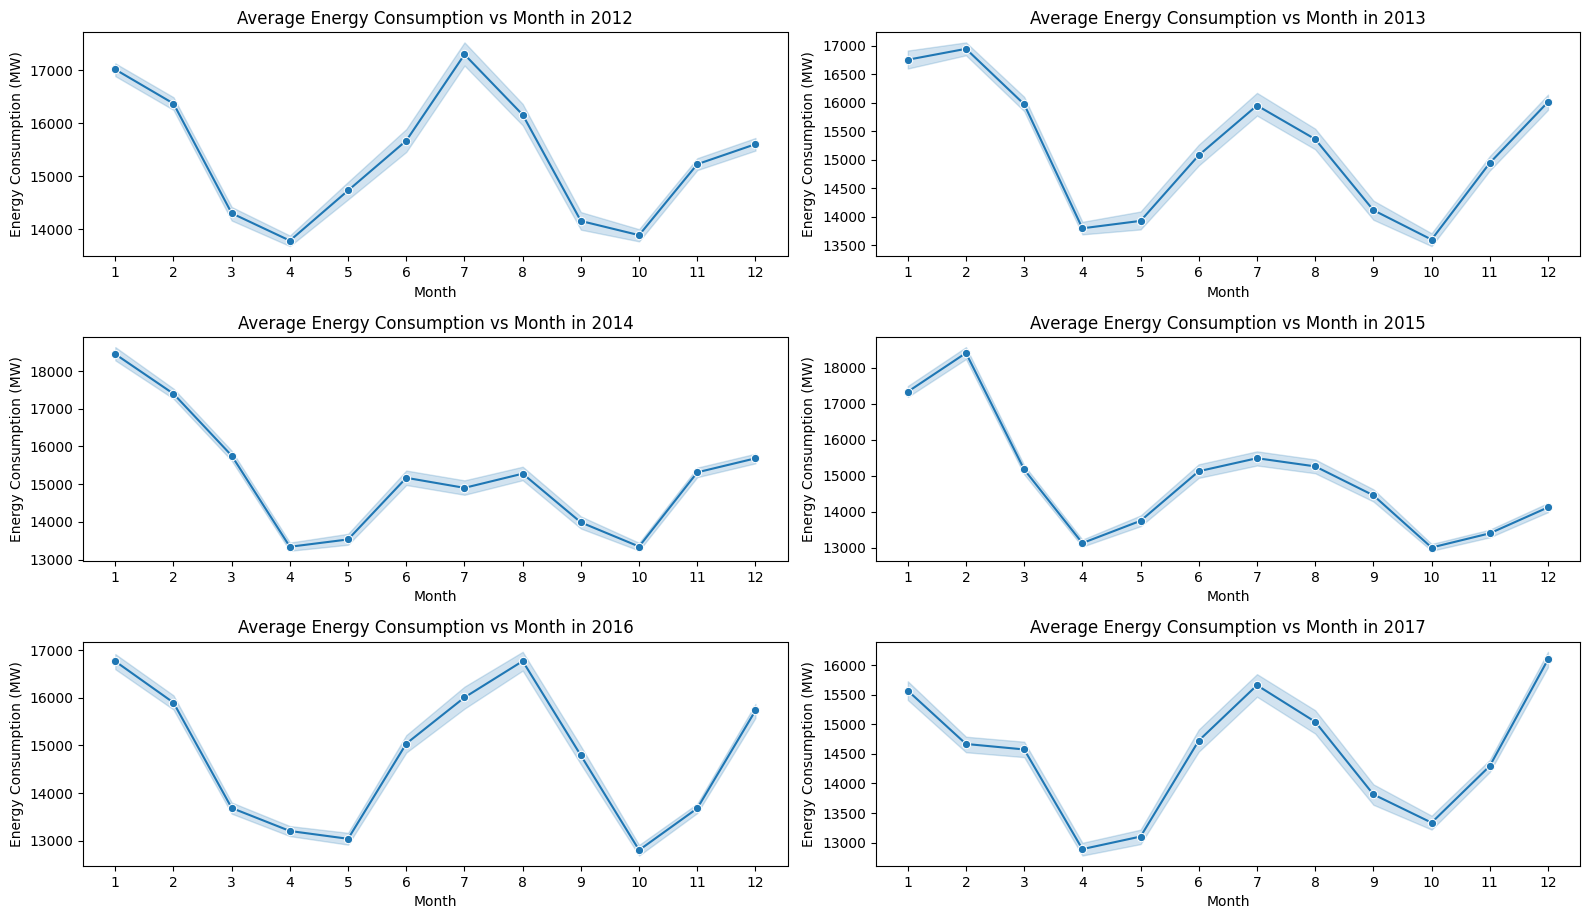

In [9]:
years_list = [2012, 2013, 2014, 2015, 2016, 2017]
plot_monthly_stats(df, years_list)

In [10]:
df.drop(columns=["Day"], inplace=True)
df.head()

,Energy_Consumption_MW,Year,Month,Dayofweek,Hour
Datetime,,,,,
2004-10-01 01:00:00,12379.0,2004,10,4,1
2004-10-01 02:00:00,11935.0,2004,10,4,2
2004-10-01 03:00:00,11692.0,2004,10,4,3
2004-10-01 04:00:00,11597.0,2004,10,4,4
2004-10-01 05:00:00,11681.0,2004,10,4,5


In [11]:
def create_sequences(
    data: NDArray[np.float64],
    seq_length: int,
    feature_indices: List[int],
    target_index: int,
) -> Tuple[NDArray[np.float64], NDArray[np.float64]]:
    """
    Create sliding window sequences and targets for time series modelling.

    Args:
        data: Scaled data array of shape (n_samples, n_features_total).
        seq_length: Length of each window (timesteps per sequence).
        feature_indices: Indices of features to include in input.
        target_index: Index of the target variable.

    Returns:
        A tuple containing:
            - X: Input sequences, shape (n_sequences, seq_length, n_features).
            - y: Target values, shape (n_sequences, 1).

    Notes:
        Each target y[i] aligns with the index at position i+seq_length in the original data.
    """
    n_features, n_samples = len(feature_indices), len(data)
    X = np.zeros((n_samples - seq_length, seq_length, n_features))
    y = np.zeros(n_samples - seq_length)
    for i in range(seq_length, n_samples):
        X[i - seq_length] = data[i - seq_length : i, feature_indices]
        y[i - seq_length] = data[i, target_index]
    X = X.reshape(-1, seq_length, n_features)
    y = y.reshape(-1, 1)
    print(f"n_samples: {n_samples}\nX.shape: {X.shape} | y.shape: {y.shape}")
    return X, y

## Preparing Dataloaders
1. Split data
2. Standardise data
3. Create sequences for train/test datasets
4. Convert subsets to tensors then to dataloaders
5. Return dataloaders & target scaler (for inverse transformation later)

In [12]:
def prepare_dataloaders(
    df: pd.DataFrame,
    seq_length: int = 90,
    input_features: Optional[List[int]] = None,
    target_index: int = 0,
    train_split: float = 0.9,
    batch_size: int = 64,
) -> Tuple[DataLoader, DataLoader, MinMaxScaler, MinMaxScaler]:
    """
    Preprocess time-series data, generate DataLoaders.

    Args:
        df: DataFrame with features and target.
        seq_length: Length of each sequence window.
        input_features: Feature indices (default all features).
        target_index: Index of the target in the columns.
        train_split: Fraction for train/test split.
        batch_size: Batch size for loaders.

    Returns:
        A tuple containing:
            - train DataLoader,
            - test DataLoader,
            - fitted features scaler,
            - fitted target scaler.
    """

    print("Processing data...")
    if input_features is None:
        input_features = list(range(len(df.columns)))

    # Chronologically split data
    split_idx = int(len(df) * train_split)
    df_train = df.iloc[:split_idx]
    df_test = df.iloc[split_idx:]

    # Fit scalers on training set only
    features_scaler = MinMaxScaler()
    target_scaler = MinMaxScaler()

    train_values = features_scaler.fit_transform(df_train.values)
    target_scaler.fit(df_train.iloc[:, target_index].values.reshape(-1, 1))

    test_values = features_scaler.transform(df_test.values)

    # Create train sequences
    X_train, y_train = create_sequences(
        train_values, seq_length, input_features, target_index
    )
    # Create test sequences
    X_test, y_test = create_sequences(
        test_values, seq_length, input_features, target_index
    )

    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

    # Create datasets and dataloaders
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    print("Dataloaders are generated!")
    return (
        train_dataloader,
        test_dataloader,
        features_scaler,
        target_scaler,
    )

In [13]:
FEATURES = list(range(len(df.columns)))  # All features
# input_features = [0, 1, 3]  # To specify
TARGET_INDEX = 0
SEQUENCE_LENGTH = 90
BATCH_SIZE = 128

train_dataloader, test_dataloader, features_scaler, target_scaler = prepare_dataloaders(
    df=df,
    input_features=FEATURES,
    target_index=TARGET_INDEX,
    seq_length=SEQUENCE_LENGTH,
    batch_size=BATCH_SIZE,
)

Processing data...
n_samples: 109145
X.shape: (109055, 90, 5) | y.shape: (109055, 1)
n_samples: 12128
X.shape: (12038, 90, 5) | y.shape: (12038, 1)
Dataloaders are generated!


In [14]:
print(f"Length of train_dataloader: {len(train_dataloader)}")
print(f"Length of test_dataloader: {len(test_dataloader)}")

Length of train_dataloader: 852
Length of test_dataloader: 95


In [15]:
train_features_batch, train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape, train_labels_batch.shape

(torch.Size([128, 90, 5]), torch.Size([128, 1]))

## Recurrent Neural Network (RNN) Architectures

### Long Short-Term Memory (LSTM)

LSTM Layer maintains two types of state tensors:
- **Hidden state($h_t$)**: Contains the output features of the LSTM cell at each time step.
- **Cell state($c_t$)**: Carries the internal memory of the LSTM cell, allowing it to preserve information over long sequences.

Both states are initialised with zeros (`init_hidden()`). After the initialisation, passing hidden states to the LSTM layer allows the model to preserve or manipulate internal states. At time step $t$, the parameteres are updates as:

$$
(h_t,c_t) = \text{LSTM}(x_t,(h_{t-1},c_{t-1}))
$$

The output of LSTM (`lstm_out`) has the shape of `[batch_size, seq_length, hidden_size]` due to `batch_first=True`. The final time step's output is represented as `lstm_out[:, -1, :]` for the whole sequence.

In [16]:
class LSTMForecaster(nn.Module):
    """
    Long Short-Term Memory (LSTM) neural network for sequence-to-one time-series forecasting.

    Attributes:
        hidden_size (int): Number of hidden units per LSTM layer.
        n_layers (int): Number of stacked LSTM layers.
        lstm (nn.LSTM): LSTM module.
        fc (nn.Linear): Fully connected linear output layer.

    Methods:
        forward(x, h=None):
            Forward pass through the model. Returns output prediction and final hidden/cell states.
        init_hidden(batch_size):
            Initialise zero hidden and cell states for LSTM, compatible with the current device.
    """

    def __init__(
        self,
        input_size: int,
        hidden_size: int,
        output_size: int,
        n_layers: int,
        drop_rate: float = 0.2,
    ) -> None:
        """
        Args:
            input_size: Dimensionality of input features.
            hidden_size: Number of hidden units per LSTM layer.
            output_size: Output dimension (usually 1 for regression).
            n_layers: Number of LSTM layers to stack.
            drop_rate: Dropout rate between LSTM layers. Defaults to 0.2.
        """
        super().__init__()
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.lstm = nn.LSTM(
            input_size,
            hidden_size,
            n_layers,
            batch_first=True,
            dropout=drop_rate,
        )
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(
        self, x: torch.Tensor, h: Optional[Tuple[torch.Tensor, torch.Tensor]] = None
    ) -> Tuple[torch.Tensor, Tuple[torch.Tensor, torch.Tensor]]:
        """
        Forward pass through the LSTMForecaster.

        Args:
            x: Input tensor of shape (batch_size, seq_length, input_size).
            h: Tuple of initial hidden and cell states. If None, states are initialised to zeros.

        Returns:
            Tuple:
                - out: Output predictions for each batch, shape (batch_size, output_size).
                - (h_n, c_n): Final hidden and cell states after the sequence.
        """
        if h is None:
            h = self.init_hidden(x.size(0))
        lstm_out, (h_n, c_n) = self.lstm(x, h)
        out = self.fc(lstm_out[:, -1, :])
        return out, (h_n, c_n)

    def init_hidden(self, batch_size: int) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        Initialise hidden and cell states for LSTM layers as zero tensors.

        Args:
            batch_size: Size of the batch.

        Returns:
            Tuple:
                - h_0 (torch.Tensor): Initial hidden state tensor.
                - c_0 (torch.Tensor): Initial cell state tensor.
            Both have shape (n_layers, batch_size, hidden_size) and are placed on the model's device.
        """
        weight = next(self.parameters())
        device = weight.device
        hidden = (
            weight.new_zeros(
                self.n_layers, batch_size, self.hidden_size, device=device
            ),  # h_0
            weight.new_zeros(
                self.n_layers, batch_size, self.hidden_size, device=device
            ),  # c_0
        )
        return hidden

### Gated Recurrent Unit (GRU)

In [17]:
class GRUForecaster(nn.Module):
    """
    Gated Recurrent Unit (GRU) neural network for sequence-to-one time-series forecasting.

    Attributes:
        hidden_size (int): Number of hidden units per GRU layer.
        n_layers (int): Number of stacked GRU layers.
        gru (nn.GRU): GRU module.
        fc (nn.Linear): Fully connected linear output layer.

    Methods:
        forward(x, h=None):
            Forward pass through the model. Returns output prediction and final hidden state.
        init_hidden(batch_size):
            Initialise zero hidden states for GRU, compatible with the current device.
    """

    def __init__(
        self,
        input_size: int,
        hidden_size: int,
        output_size: int,
        n_layers: int,
        drop_rate: float = 0.2,
    ) -> None:
        """
        Args:
            input_size: Dimensionality of input features.
            hidden_size: Number of hidden units per GRU layer.
            output_size: Output dimension (usually 1 for regression).
            n_layers: Number of GRU layers to stack.
            drop_rate: Dropout rate between GRU layers. Defaults to 0.2.
        """
        super().__init__()
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.gru = nn.GRU(
            input_size,
            hidden_size,
            n_layers,
            batch_first=True,
            dropout=drop_rate,
        )
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(
        self, x: torch.Tensor, h: Optional[Tuple[torch.Tensor]] = None
    ) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        Forward pass through the GRUForecaster.

        Args:
            x: Input tensor of shape (batch_size, seq_length, input_size).
            h: Initial hidden state tensor. If None, state is initialised to zeros.

        Returns:
            tuple:
                - out: Output predictions for each batch, shape (batch_size, output_size).
                - h_n: Final hidden state after the sequence.
        """
        if h is None:
            h = self.init_hidden(x.size(0))
        gru_out, h_n = self.gru(x, h)
        out = self.fc(gru_out[:, -1, :])
        return out, h_n

    def init_hidden(self, batch_size: int) -> torch.Tensor:
        """
        Initialise hidden state for GRU layers as a zero tensor.

        Args:
            batch_size: Size of the batch.

        Returns:
            Initial hidden state of shape (n_layers, batch_size, hidden_size) placed on the model's device.
        """
        weight = next(self.parameters())
        device = weight.device
        hidden = (
            weight.new_zeros(
                self.n_layers, batch_size, self.hidden_size, device=device
            )  # h_0
        )
        return hidden

In [18]:
HIDDEN_SIZE = 256
INPUT_SIZE = len(FEATURES)
OUTPUT_SIZE = 1
N_LAYERS = 2
LEARNING_RATE = 0.001
EPOCHS = 5
lstm_model = LSTMForecaster(INPUT_SIZE, HIDDEN_SIZE, OUTPUT_SIZE, N_LAYERS)
gru_model = GRUForecaster(INPUT_SIZE, HIDDEN_SIZE, OUTPUT_SIZE, N_LAYERS)

In [19]:
from torchinfo import summary

for model in [lstm_model, gru_model]:
    print(
        summary(
            model,
            input_size=(
                BATCH_SIZE,
                SEQUENCE_LENGTH,
                INPUT_SIZE,
            ),  # (batch size, sequence length, input size)
            verbose=0,
            col_names=["input_size", "output_size", "num_params", "trainable"],
            col_width=20,
            row_settings=["var_names"],
            device=device,
        )
    )
    print("\n")

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
LSTMForecaster (LSTMForecaster)          [128, 90, 5]         [128, 1]             --                   True
├─LSTM (lstm)                            [128, 90, 5]         [128, 90, 256]       795,648              True
├─Linear (fc)                            [128, 256]           [128, 1]             257                  True
Total params: 795,905
Trainable params: 795,905
Non-trainable params: 0
Total mult-adds (Units.GIGABYTES): 9.17
Input size (MB): 0.23
Forward/backward pass size (MB): 23.59
Params size (MB): 3.18
Estimated Total Size (MB): 27.01


Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
GRUForecaster (GRUForecaster)            [128, 90, 5]         [128, 1]             --                   True
├─GRU (gru)                              [128, 90, 5]         [128, 90, 256]       596,736              T

##  Evaluation Metrics
For regression tasks with the RNN, common evaluation metrics are:
- Mean Squared Error (MSE)
- Root Mean Squared Error (RMSE)
- Mean Absolute Error(RMSE)
- Mean Absolute Percentage Error (MAPE)
- Symmetric Mean Absolute Percentage Error (sMAPE)

We will use RMSE and sMAPE.

### Root Mean Squared Error (RMSE)

$$
\text{RMSE} = \sqrt{\text{MSE}} = \sqrt{\dfrac{1}{N} \sum_{ni1}^{N}(y_i - \hat y_i)^2}
$$

where:
- $y_i$: Actual values
- $\hat y_i$: Predicted values
- $N$: Number of samples

### Mean Absolute Percentage Error (MAPE)
MAPE is a commonly used metrics to measure the accuracy of a regression forecasting model. It expresses the average magnitude of the errors between predicted values and actual values as a percentage, making it easy to interpret and compare across different datasets and models. For example, a MAPE value of 8% means predictions are off by 8% on average.

$$
\text{MAPE} = \dfrac{100}{N}\sum^{N}_{i=1}\left|\dfrac{y_i - \hat y_i}{y_i + \epsilon}\right|
$$

### Symmetric Mean Absolute Percentage Error (sMAPE)
MAPE becomes undefined or extremely large when actual values $y_i$ are zero or near zero. sMAPE improves MAPE by symmetrising the percentage error to avoid bias and instability.

$$
\text{sMAPE} = \dfrac{100}{N}\sum^{N}_{i=1}\dfrac{2\left|y_i - \hat y_i\right|}{\left|y_i\right| + \left|\hat y_i\right| + \epsilon} = \dfrac{200}{N}\sum^{N}_{i=1}\dfrac{\left|y_i - \hat y_i\right|}{\left|y_i\right| + \left|\hat y_i\right| + \epsilon}
$$

where $\epsilon$ is a small constant(e.g., $1 \times 10^{-8}$).

## Loss Function
### Mean Squared Error
Mean Squared Error measures the average squared difference between predicted ($\hat y$) and actual ($y$) values. Large errors are penalised heavily. Smaller MSE indicates better predictions.

\begin{align*}
MSE = \dfrac{1}{N} \sum_{i=1}^{N}(\hat y_{i} - y_{i})^2
\end{align*}

In [20]:
loss_function = nn.MSELoss()  # Mean Squared Error

## Optimiser
An optimiser in neural networks is used to adjust the parameters (weights and biases) of a model during training to minimise the loss. Optimisers are essential for enabling neural networks to learn from data: without them, the model would not improve over time.

In [21]:
lstm_optimiser = torch.optim.Adam(lstm_model.parameters(), lr=LEARNING_RATE)
gru_optimiser = torch.optim.Adam(gru_model.parameters(), lr=LEARNING_RATE)

## Training and Evaluation
1. Iterate through epochs
1. For each epoch, iterate through training batches, perform training steps, calculate the train loss and evaluation metrics per batch.
1. For each epoch, iterate through testing batches, perform testing steps, calculate the test loss and evaluation metrics per batch.
1. Store the results.

### Training Steps
1. Forward pass
    - Pass inputs through the model to obtain predictions.
1. Calculate loss and evaluation metrics per batch
    - Measure how far the predictions deviate from the true labels, using a loss function.
    - Compute evaluation metrics for the current batch.
1. Zero the gradients
    - Clear the previously stored gradients to prevent accumulation from multiple backward passes.
1. Backward pass
    - Computes gradients of the loss with respect to the model's parameters via backpropagation.
1. Optimiser step
    - Update the parameter $\theta$ using the gradients just computed, typically following an equation such as:
    $$
        \theta \leftarrow \theta - \eta \dfrac{\partial \mathcal{L}}{\partial \theta}
    $$
    where $\eta$ is the learning rate.
1. Average training loss and evaluation metrics
    - Calcualte the means of loss function and evaluation metrics across all batches for the epoch.

In [22]:
def train_step(
    model: nn.Module,
    data_loader: DataLoader,
    loss_function: nn.Module,
    optimiser: torch.optim.Optimizer,
    device: torch.device,
) -> Tuple[float, Tuple[float, float]]:
    """
    Perform one epoch of training.

    Args:
        model: The PyTorch model to train.
        data_loader: DataLoader providing training batches.
        loss_function: Loss function for optimisation.
        optimiser: Optimiser to update model parameters.
        device: Device to perform training on (CPU/GPU).

    Returns:
        Tuple:
            avg_train_loss: Average training loss over all batches.
            train_metrics: Tuple containing average RMSE and average sMAPE over all batches.
    """
    model.train()
    avg_train_loss = 0.0
    avg_train_rmse = 0.0
    avg_train_smape = 0.0

    for batch, (X, y) in tqdm(enumerate(data_loader), total=len(data_loader)):
        X, y = X.to(device), y.to(device)
        batch_size = X.size(0)
        h = model.init_hidden(batch_size)

        # 1. Forward Pass
        y_pred, h = model(X, h)

        # 2. Calculate loss per batch, RMSE and sMAPE (with epsilon)
        loss = loss_function(y_pred, y)
        avg_train_loss += loss.item()

        rmse_batch = torch.sqrt(torch.mean((y - y_pred) ** 2)).item()
        smape_batch = (
            torch.mean(
                2 * torch.abs((y - y_pred) / (torch.abs(y) + torch.abs(y_pred) + 1e-8))
            )
            * 100
        ).item()
        avg_train_rmse += rmse_batch
        avg_train_smape += smape_batch

        # 3. Optimiser zero grad
        optimiser.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimiser step
        optimiser.step()

        # if batch % 200 == 0 and batch > 0:
        #     print(
        #         f"Step: {batch}/{len(data_loader)} - Train Loss: {avg_train_loss / (batch + 1)}"
        #     )
        #     print(f"Train RMSE: {rmse_batch} | Train MAPE: {mape_batch}")

    # 6. Average training loss and evaluation metrics
    avg_train_loss /= len(data_loader)
    avg_train_rmse /= len(data_loader)
    avg_train_smape /= len(data_loader)
    print(
        f"Train Loss: {avg_train_loss:.8f} | Train RMSE: {avg_train_rmse:.4f} | Train sMAPE: {avg_train_smape:.4f}"
    )
    train_metrics = [avg_train_rmse, avg_train_smape]
    return avg_train_loss, train_metrics

### Testing Steps
1. Forward pass
    - Set the model to evaluation mode (which disables dropout and batch normalisation and desactivates gradient tracking for safety).
    - Pass inputs through the model to obtain predictions.
2. Calculate loss and evaluation metrics per batch
    - Measures how far the predictions deviate from the true labels, using a loss function.
    - Compute evaluation metrics for the current batch.
3. Average test loss and evaluation metrics
    - Calcualte the means of loss function and evaluation metrics across all batches for the epoch.

In [23]:
def test_step(
    model: torch.nn.Module,
    data_loader: DataLoader,
    loss_function: torch.nn.Module,
    device: torch.device,
) -> Tuple[float, Tuple[float, float]]:
    """
    Evaluate the model on the test dataset.

    Args:
        model: The PyTorch model to evaluate.
        data_loader: DataLoader providing test batches.
        loss_function: Loss function to evaluate.
        device: Device to perform evaluation on.

    Returns:
        Tuple:
            avg_test_loss: Average test loss over all batches.
            test_metrics: Tuple containing average RMSE and average sMAPE over all batches.
    """
    model.eval()
    avg_test_loss = 0.0
    avg_test_rmse = 0.0
    avg_test_smape = 0.0

    with torch.inference_mode():
        for batch, (X, y) in tqdm(enumerate(data_loader), total=len(data_loader)):
            X, y = X.to(device), y.to(device)
            batch_size = X.size(0)
            h = model.init_hidden(batch_size)

            # 1. Forward pass
            y_pred, h = model(X, h)

            # 2. Calculate loss per batch, RMSE and sMAPE (with epsilon)
            loss = loss_function(y_pred, y)
            avg_test_loss += loss.item()

            rmse_batch = torch.sqrt(torch.mean((y - y_pred) ** 2)).item()
            smape_batch = (
                torch.mean(
                    2
                    * torch.abs(
                        (y - y_pred) / (torch.abs(y) + torch.abs(y_pred) + 1e-8)
                    )
                )
                * 100
            ).item()

            avg_test_rmse += rmse_batch
            avg_test_smape += smape_batch

    # 3. Average test loss and evaluation metrics
    avg_test_loss /= len(data_loader)
    avg_test_rmse /= len(data_loader)
    avg_test_smape /= len(data_loader)
    print(
        f"Test Loss: {avg_test_loss:.8f} | Test RMSE: {avg_test_rmse:.4f} | Test sMAPE: {avg_test_smape:.4f} \n"
    )
    test_metrics = [avg_test_rmse, avg_test_smape]
    return avg_test_loss, test_metrics


### Training and Validating

In [24]:
def train_and_validate(
    model: nn.Module,
    train_dataloader: DataLoader,
    test_dataloader: DataLoader,
    loss_function: nn.Module,
    optimiser: torch.optim.Optimizer,
    device: torch.device,
    total_epochs: int,
) -> Tuple[Dict[str, List[float]], Dict[str, List[float]]]:
    """
    Train and evaluate the model over multiple epochs.

    Args:
        model: The PyTorch model to train and evaluate.
        train_dataloader: DataLoader for the training set.
        test_dataloader: DataLoader for the test set.
        loss_function: Loss function.
        optimiser: Optimiser for training.
        device: Device to run the training on.
        total_epochs: Total number of epochs to train.

    Returns:
        Tuple:
            train_results: Dictionary storing lists of training losses and metrics per epoch.
            test_results: Dictionary storing lists of test losses and metrics per epoch.
    """
    model.to(device)
    epochs_range = range(1, total_epochs + 1)
    train_results = {
        "Loss": [],
        "RMSE": [],
        "sMAPE": [],
    }

    test_results = {
        "Loss": [],
        "RMSE": [],
        "sMAPE": [],
    }
    for epoch in epochs_range:
        print(f"Epoch: {epoch}/{total_epochs}\n==========")
        train_loss, train_metrics = train_step(
            data_loader=train_dataloader,
            model=model,
            loss_function=loss_function,
            optimiser=optimiser,
            device=device,
        )

        train_results["Loss"].append(train_loss)
        train_results["RMSE"].append(train_metrics[0])
        train_results["sMAPE"].append(train_metrics[1])

        test_loss, test_metrics = test_step(
            data_loader=test_dataloader,
            model=model,
            loss_function=loss_function,
            device=device,
        )

        test_results["Loss"].append(test_loss)
        test_results["RMSE"].append(test_metrics[0])
        test_results["sMAPE"].append(test_metrics[1])
    return train_results, test_results

### Performance Evaluation (LSTM)

In [25]:
lstm_train_results, lstm_test_results = train_and_validate(
    lstm_model,
    train_dataloader,
    test_dataloader,
    loss_function,
    lstm_optimiser,
    device,
    EPOCHS,
)

Epoch: 1/5


100%|██████████| 852/852 [03:18<00:00,  4.29it/s]


Train Loss: 0.00322684 | Train RMSE: 0.0436 | Train sMAPE: 11.1573


100%|██████████| 95/95 [00:08<00:00, 11.14it/s]


Test Loss: 0.00029732 | Test RMSE: 0.0171 | Test sMAPE: 5.4342 

Epoch: 2/5


100%|██████████| 852/852 [03:21<00:00,  4.23it/s]


Train Loss: 0.00040565 | Train RMSE: 0.0199 | Train sMAPE: 5.0750


100%|██████████| 95/95 [00:10<00:00,  9.29it/s]


Test Loss: 0.00019247 | Test RMSE: 0.0137 | Test sMAPE: 4.0211 

Epoch: 3/5


100%|██████████| 852/852 [03:42<00:00,  3.84it/s]


Train Loss: 0.00027424 | Train RMSE: 0.0164 | Train sMAPE: 4.1222


100%|██████████| 95/95 [00:10<00:00,  8.76it/s]


Test Loss: 0.00023905 | Test RMSE: 0.0152 | Test sMAPE: 4.2733 

Epoch: 4/5


100%|██████████| 852/852 [03:55<00:00,  3.62it/s]


Train Loss: 0.00023948 | Train RMSE: 0.0152 | Train sMAPE: 3.8143


100%|██████████| 95/95 [00:11<00:00,  8.55it/s]


Test Loss: 0.00015059 | Test RMSE: 0.0121 | Test sMAPE: 3.6762 

Epoch: 5/5


100%|██████████| 852/852 [03:57<00:00,  3.58it/s]


Train Loss: 0.00021099 | Train RMSE: 0.0142 | Train sMAPE: 3.5708


100%|██████████| 95/95 [00:10<00:00,  8.91it/s]

Test Loss: 0.00010454 | Test RMSE: 0.0101 | Test sMAPE: 3.2580 



### Performance Evaluation (GRU)

In [26]:
gru_train_results, gru_test_results = train_and_validate(
    gru_model,
    train_dataloader,
    test_dataloader,
    loss_function,
    gru_optimiser,
    device,
    EPOCHS,
)

Epoch: 1/5


100%|██████████| 852/852 [02:59<00:00,  4.76it/s]


Train Loss: 0.00178598 | Train RMSE: 0.0342 | Train sMAPE: 8.6042


100%|██████████| 95/95 [00:07<00:00, 12.46it/s]


Test Loss: 0.00041664 | Test RMSE: 0.0203 | Test sMAPE: 7.2732 

Epoch: 2/5


100%|██████████| 852/852 [03:05<00:00,  4.59it/s]


Train Loss: 0.00034790 | Train RMSE: 0.0183 | Train sMAPE: 4.6315


100%|██████████| 95/95 [00:08<00:00, 11.87it/s]


Test Loss: 0.00016110 | Test RMSE: 0.0126 | Test sMAPE: 4.1740 

Epoch: 3/5


100%|██████████| 852/852 [03:14<00:00,  4.39it/s]


Train Loss: 0.00026002 | Train RMSE: 0.0159 | Train sMAPE: 4.0022


100%|██████████| 95/95 [00:10<00:00,  8.73it/s]


Test Loss: 0.00015992 | Test RMSE: 0.0125 | Test sMAPE: 3.6876 

Epoch: 4/5


100%|██████████| 852/852 [03:20<00:00,  4.24it/s]


Train Loss: 0.00022253 | Train RMSE: 0.0147 | Train sMAPE: 3.7134


100%|██████████| 95/95 [00:08<00:00, 11.41it/s]


Test Loss: 0.00022966 | Test RMSE: 0.0150 | Test sMAPE: 5.0677 

Epoch: 5/5


100%|██████████| 852/852 [03:43<00:00,  3.82it/s]


Train Loss: 0.00020601 | Train RMSE: 0.0141 | Train sMAPE: 3.5822


100%|██████████| 95/95 [00:11<00:00,  8.21it/s]

Test Loss: 0.00014310 | Test RMSE: 0.0118 | Test sMAPE: 3.6332 



## Results
### Overall Performance

In [27]:
def plot_performance(
    model_name: str,
    total_epochs: int,
    train_metrics: Dict[str, List[float]],
    test_metrics: Dict[str, List[float]],
) -> None:
    """
    Plot training and testing metrics over epochs.

    Args:
        model_name: Name of the model for plot titles.
        total_epochs: Number of training epochs.
        train_metrics: Dictionary of training metrics.
        test_metrics: Dictionary of testing metrics.
    """
    epochs_range = range(1, total_epochs + 1)
    metric_names = list(train_metrics.keys())
    n_metrics = len(metric_names)
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16, 6))
    axes = axes.flatten()

    for i, metric_name in enumerate(metric_names):
        ax = axes[i]
        ax.plot(
            epochs_range, train_metrics[metric_name], label=f"Train {metric_name}"
        )  # Train metric
        ax.plot(
            epochs_range, test_metrics[metric_name], label=f"Test {metric_name}"
        )  # Test metric
        ax.set_title(f"{metric_name} Over Epochs ({model_name})", fontsize=15)
        ax.legend()
        ax.set_xlabel("Epoch")
        ax.set_ylabel(metric_name)

    if n_metrics < len(axes):
        for j in range(n_metrics, len(axes)):
            plt.delaxes(axes[j])
    plt.tight_layout()
    plt.show()

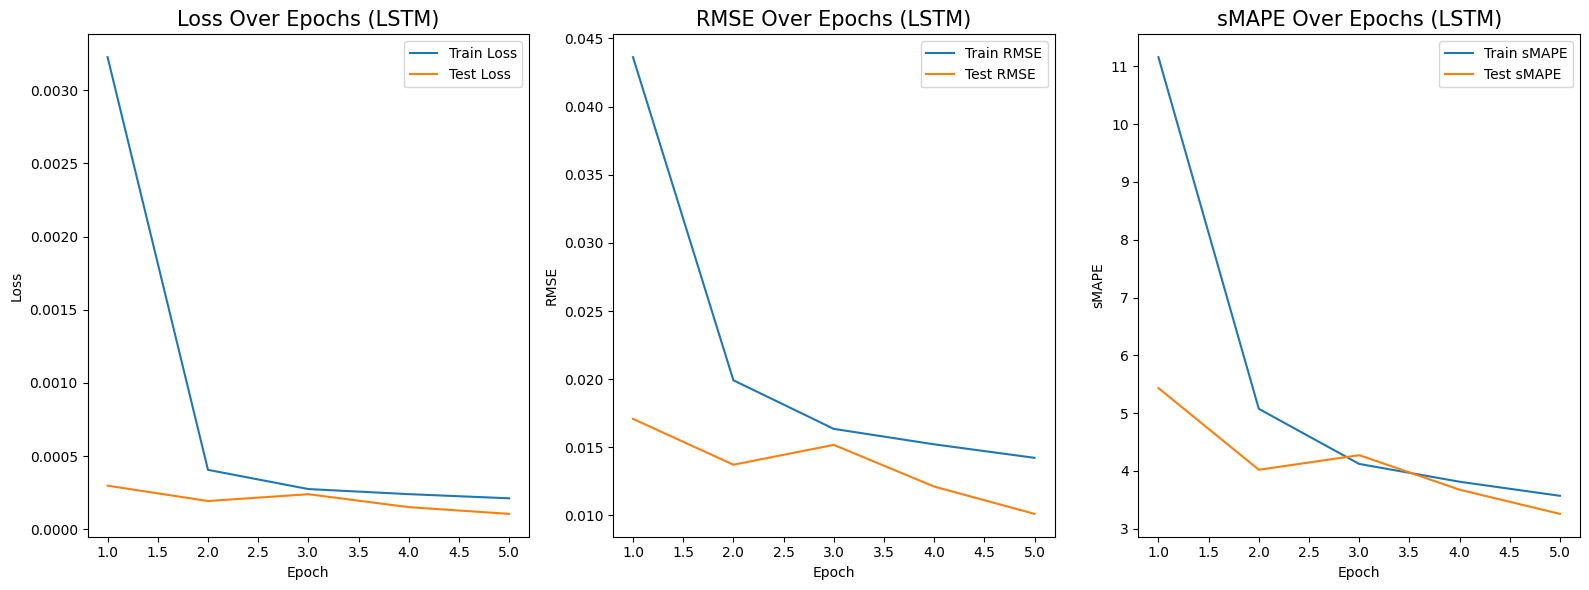

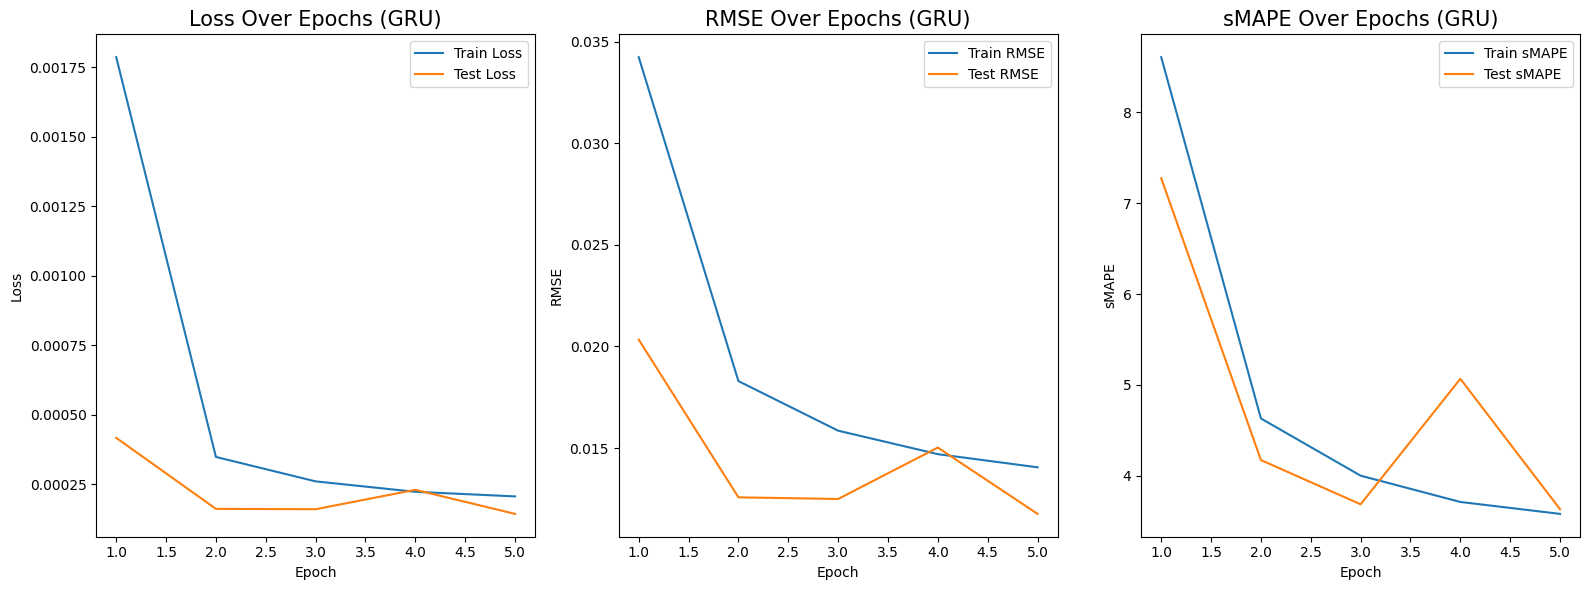

In [28]:
plot_performance("LSTM", EPOCHS, lstm_train_results, lstm_test_results)
plot_performance("GRU", EPOCHS, gru_train_results, gru_test_results)

## Prediction

In [29]:
def make_predictions(
    model: torch.nn.Module,
    data_loader: DataLoader,
    device: torch.device,
) -> Tuple[NDArray[np.float32], NDArray[np.float32]]:
    """
    Generate predictions and collect true targets from the DataLoader.

    Args:
        model: Trained PyTorch model for inference.
        data_loader: DataLoader containing the dataset to predict on.
        device: Device to run inference on.

    Returns:
        Tuple:
            all_predictions: NumPy array of all model predictions.
            all_targets: NumPy array of corresponding true targets.
    """
    all_predictions = []
    all_targets = []
    model.eval()
    with torch.inference_mode():
        for X, y in data_loader:
            X = X.to(device)
            batch_size = X.size(0)
            h = model.init_hidden(batch_size)

            # Forward pass for predictions
            y_pred, h = model(X, h)
            all_predictions.append(y_pred.cpu())
            all_targets.append(y.cpu())
    all_predictions = torch.cat(all_predictions, dim=0).numpy()
    all_targets = torch.cat(all_targets, dim=0).numpy()
    return all_predictions, all_targets

In [32]:
lstm_all_preds, all_actual_y = make_predictions(lstm_model, test_dataloader, device)
lstm_all_preds_unscaled = target_scaler.inverse_transform(lstm_all_preds)
all_actual_y_unscaled = target_scaler.inverse_transform(all_actual_y)

gru_all_preds, _ = make_predictions(gru_model, test_dataloader, device)
gru_all_preds_unscaled = target_scaler.inverse_transform(gru_all_preds)

In [33]:
# Extract the corresponding datetimes: [-12038:] (The last 12038 values)
test_datetimes = df.index[-all_actual_y_unscaled.shape[0] :]

In [34]:
result_df = pd.DataFrame(
    {
        "datetime": test_datetimes,
        "actual_y": all_actual_y_unscaled.flatten(),
        "lstm": lstm_all_preds_unscaled.flatten(),
        "gru": gru_all_preds_unscaled.flatten(),
    }
)
result_df.set_index("datetime", inplace=True)

print(result_df.head())

                         actual_y          lstm           gru
datetime                                                     
2017-03-19 11:00:00  14322.000000  14370.662109  14493.421875
2017-03-19 12:00:00  14183.999023  14157.873047  14194.452148
2017-03-19 13:00:00  14098.000000  14007.554688  14000.751953
2017-03-19 14:00:00  13883.000000  13954.105469  13954.699219
2017-03-19 15:00:00  13609.000000  13738.279297  13718.440430


In [35]:
def plot_predictions(results: pd.DataFrame, n_points: int) -> None:
    """
    Plot actual and predicted energy consumption values from LSTM and GRU models.

    Args:
        results: DataFrame containing the columns 'actual_y', 'lstm', and 'gru'.
            The DataFrame index should correspond to the datetime or sequence order.
        n_points: Number of points (time steps) to plot from the results DataFrame.

    Notes:
        The function is intended for quick visual assessment of model performance over time.
        Ensure all values in `results` are unscaled and in physical units (e.g., MW) for meaningful interpretation.
    """

    plt.figure(figsize=(12, 6))
    plt.plot(results["actual_y"][:n_points], label="Actual Values", color="blue")
    plt.plot(
        results["lstm"][:n_points],
        label="LSTM Predictions",
        color="red",
        linestyle="dashed",
    )
    plt.plot(
        results["gru"][:n_points],
        label="GRU Predictions",
        color="orange",
        linestyle="dashed",
    )
    plt.xlabel("Time Step")
    plt.ylabel("Energy Consumption (MW)")
    plt.title("Comparison of Actual vs Predicted Energy Consumption")
    plt.legend()
    plt.tight_layout()
    plt.show()

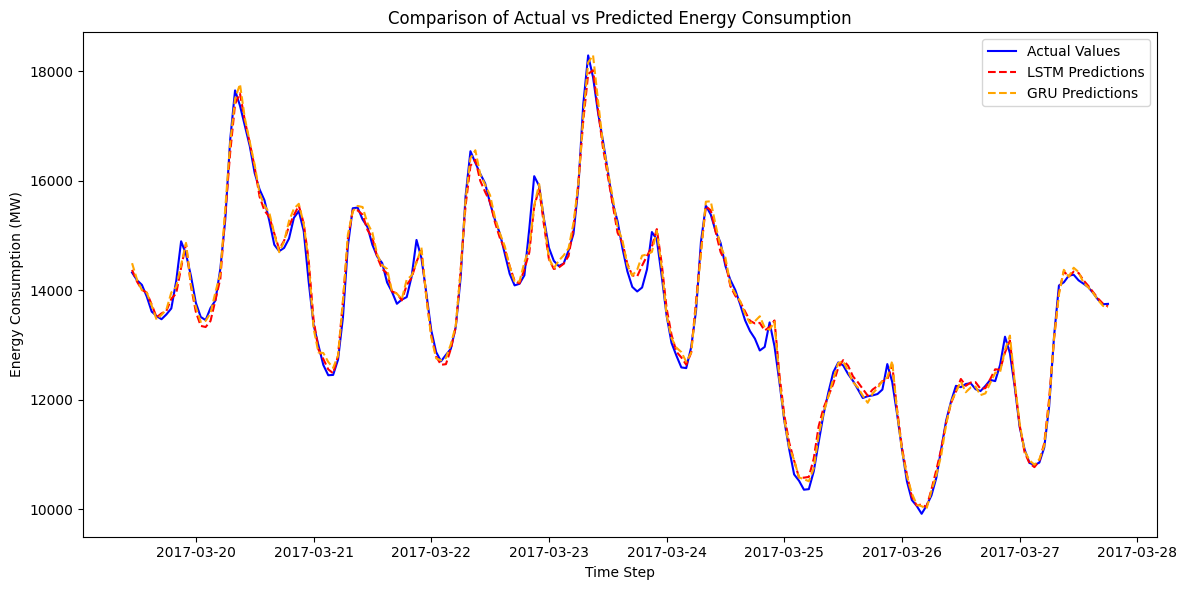

In [36]:
N_points = 200
plot_predictions(result_df, N_points)

1. Coralogic Team. (2023). *A Comprehensive Guide to Mean Absolute Percentage Error (MAPE)*.<br>
https://coralogix.com/ai-blog/a-comprehensive-guide-to-mean-absolute-percentage-error-mape/

1. Encode. (2023). *Time Series Predictions with RNNs*.<br>
https://encord.com/blog/time-series-predictions-with-recurrent-neural-networks/#:~:text=To%20assess%20the%20performance%20of,Absolute%20Percentage%20Error%20(MAPE).

1. GeeksforGeeks. (2025). *Gated Recurrent Unit Networks*.<br>
https://www.geeksforgeeks.org/machine-learning/gated-recurrent-unit-networks/

1. GeeksforGeeks. (2025). *What is LSTM - Long Short Term Memory?*<br>
https://www.geeksforgeeks.org/deep-learning/deep-learning-introduction-to-long-short-term-memory/

1. Github - Issues. (2025). *Memory Leak in MPS Backend During LSTM Iterations (Out of Memory Error)*.<br>
https://github.com/pytorch/pytorch/issues/145374

1. Github - Issues. (2023). *MPS backend produces bad training results in comparison to other backends*.<br>
https://github.com/pytorch/pytorch/issues/92615

1. Github - Issues. (2023). *Training results from using MPS backend are poor compared to CPU and CUDA*.<br>
https://github.com/pytorch/pytorch/issues/109457
